<a href="https://colab.research.google.com/github/hadiwyne/sql-project/blob/main/chinook_db_investigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chinook Database Project

Chinook is a very popular database for a fictional music store called Chinook. The databse can be found here as [`chinook.db`](https://github.com/lerocha/chinook-database/blob/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite). There are many different tables in this databse containing information about:
- employees
- customers
- invoice
- playlist
- artist
- album
- track
- media type
- genre

And each of these tables contain even more information. For this project, our role is that of a data analysts for the Chinook record store, and we will be answering important business questions using SQL queries.

The reason I've chosen to use Jupyter Notebook for this project, even though this is a SQL project, is because Jupyter Notebook allows me to write about my each step of this project using Markdown cells, and upload it to my portfolio on [GitHub](https://github.com/hadiwyne).  

## Opening a .db file in Jupyter Notebook

- We begin by importing the `sqlite3` python library that will allow us to execute SQL queries in a Notebook environment.
- We then import `pandas` which will allow us to render the tables as pandas dataframe. This will look convenient in a Notebook environment.

In [4]:
import sqlite3
import pandas as pd

In [5]:
conn = sqlite3.connect('Chinook_Sqlite.sqlite')

# Data exploration

Now, let's begin by looking at our table names.

In [6]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)
print(tables)

             name
0           Album
1          Artist
2        Customer
3        Employee
4           Genre
5         Invoice
6     InvoiceLine
7       MediaType
8        Playlist
9   PlaylistTrack
10          Track


Now, we will perform a query to view the first 10 items in the `Track` table. If we had not used the `LIMIT 10` limiter, the query would've returned us all the items in the table. This is why it is important to set a limit.

Notice that because this is being rendered as a pandas dataframe, we get two indexes:
1. The `TrackID` index, which starts with 1
2. The `pandas` index, which starts with 0.

We are only interested in the

In [7]:
query = "SELECT * FROM Track LIMIT 10;"
pd.read_sql(query, conn)

,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
1,2,Balls to the Wall,2,2,1,None,342562,5510424,0.99
2,3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",230619,3990994,0.99
3,4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",252051,4331779,0.99
4,5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99
5,6,Put The Finger On You,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",205662,6713451,0.99
6,7,Let's Get It Up,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",233926,7636561,0.99
7,8,Inject The Venom,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",210834,6852860,0.99
8,9,Snowballed,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",203102,6599424,0.99
9,10,Evil Walks,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",263497,8611245,0.99


## Our task is to discover the artists with profitable genres in the US.

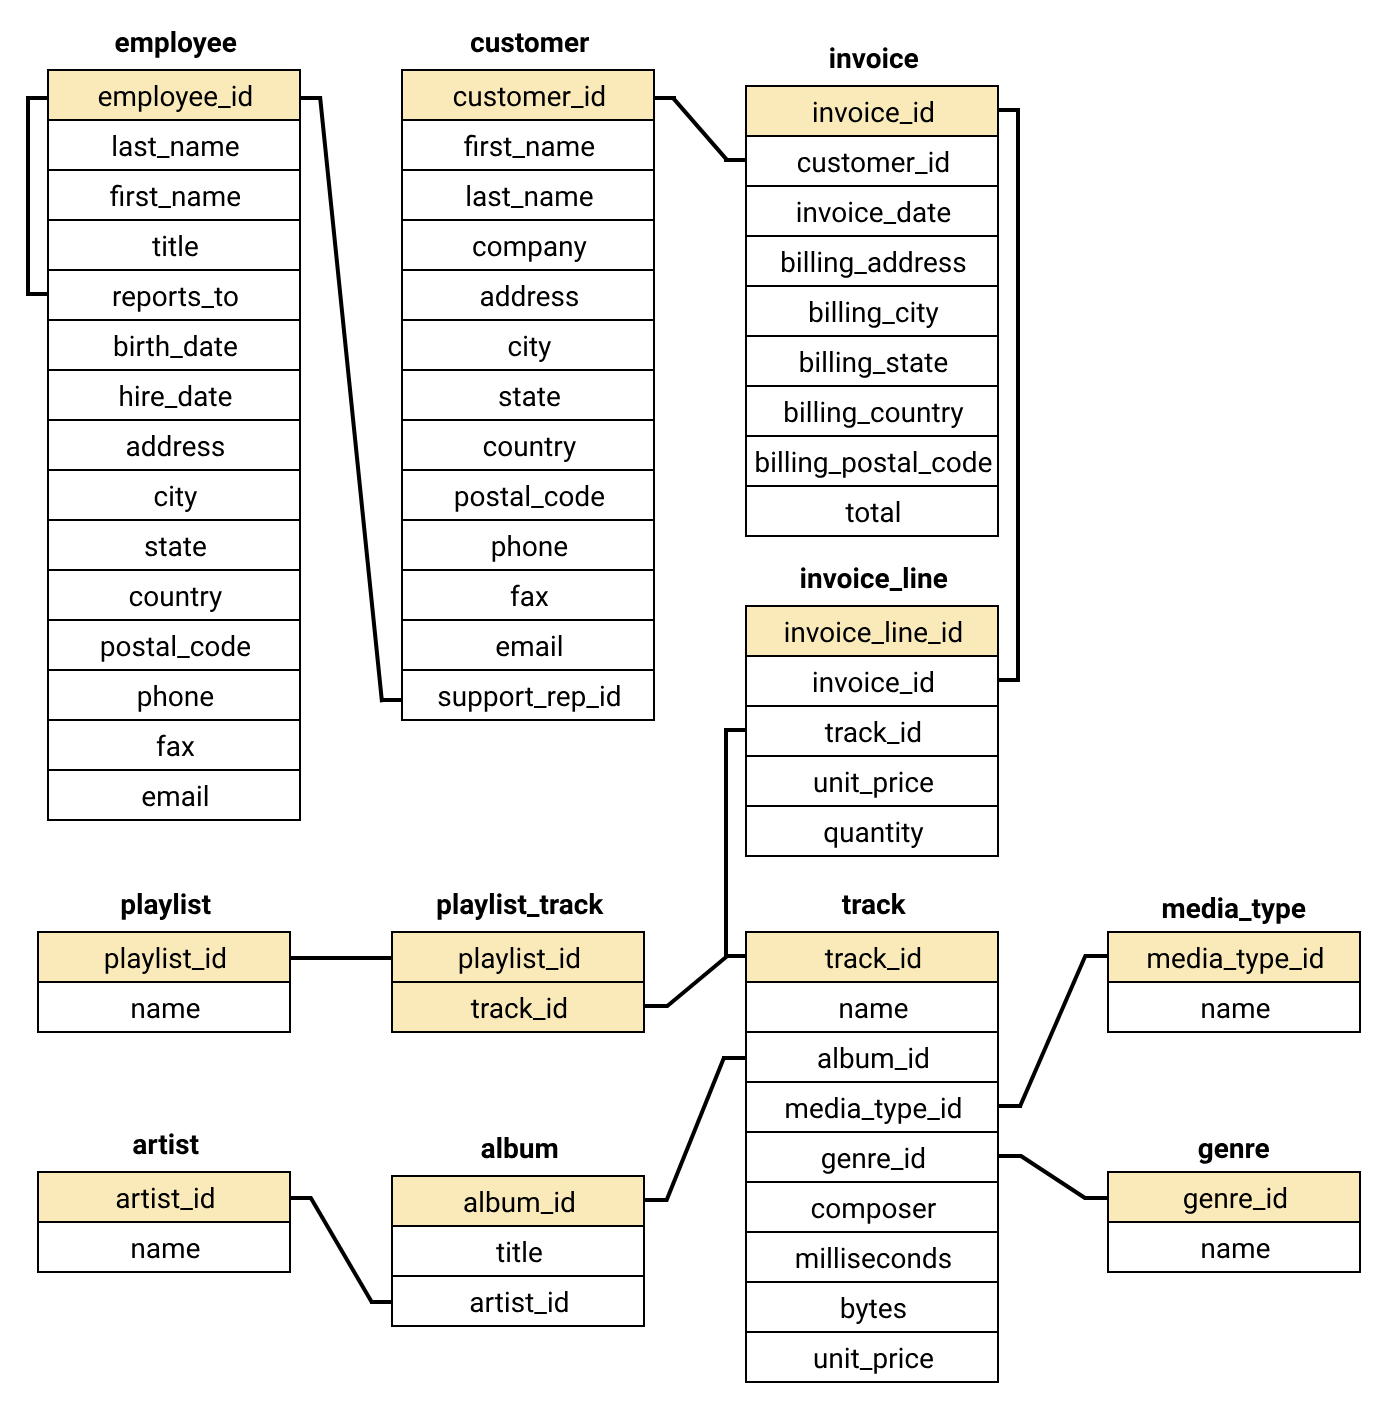

# Combining Tables

If we look at the ERD, we can see that the table of our concern is called `genre`. Furthermore, we will investigate the `billing_country` section in the `invoice` table. And since we also want to investigate the number of tracks being sold, we will also be investigating the `Track` table.

For this task, we will combine several different tables together, which can be achieved by the following query.

This query will use a **Common Table Expression (CTE)**, which starts with `WITH`. This allows us to create a temporary table, to be used with other SQL queries as well. Unlike `VIEWS` which permanently alter the database, CTES are temporary and do not modify the original database.

In [8]:
query = """

SELECT *
FROM invoice
LIMIT 10;

"""

pd.read_sql(query, conn)

,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,1,2,2009-01-01 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
1,2,4,2009-01-02 00:00:00,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
2,3,8,2009-01-03 00:00:00,Grétrystraat 63,Brussels,None,Belgium,1000,5.94
3,4,14,2009-01-06 00:00:00,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91
4,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86
5,6,37,2009-01-19 00:00:00,Berger Straße 10,Frankfurt,None,Germany,60316,0.99
6,7,38,2009-02-01 00:00:00,Barbarossastraße 19,Berlin,None,Germany,10779,1.98
7,8,40,2009-02-01 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98
8,9,42,2009-02-02 00:00:00,"9, Place Louis Barthou",Bordeaux,None,France,33000,3.96
9,10,46,2009-02-03 00:00:00,3 Chatham Street,Dublin,Dublin,Ireland,None,5.94


In [9]:
query = """
WITH genre_usa_tracks AS (
    SELECT
        il.InvoiceLineId,
        g.name AS genre,
        t.TrackId,
        i.BillingCountry AS country
    FROM track AS t
    JOIN genre as g
        ON t.GenreId = g.GenreId
    JOIN InvoiceLine as il
        ON t.TrackId = il.TrackId
    JOIN invoice AS i
        ON il.InvoiceId = i.InvoiceId
    WHERE i.BillingCountry = 'USA'
)
SELECT
    genre,
    COUNT(*) AS count,
    CAST (COUNT(*) AS float) / (SELECT COUNT(*) FROM genre_usa_tracks) AS percentage
FROM genre_usa_tracks
GROUP BY genre
ORDER BY count DESC;
"""
pd.read_sql(query, conn)

,genre,count,percentage
0,Rock,157,0.317814
1,Latin,91,0.184211
2,Metal,64,0.129555
3,Alternative & Punk,50,0.101215
4,Jazz,22,0.044534
5,Blues,15,0.030364
6,TV Shows,14,0.028340
7,R&B/Soul,12,0.024291
8,Comedy,8,0.016194
9,Classical,8,0.016194


Here we have picked up `InvoiceLineId` from `InvoiceLine` table and joined it with the `name` portion from the `genre` table, here aliased as `genre` for easier reference.These are then joined with the `TrackId` portion from the `Track` table. And the last column is the `billing country` from the invoice, aliased as country.

Once this combined table was created, we performed another query to get an aggregated count of all the genres. After this, we performed a sub-query (a query nested within a query) to calculate the percentage of the albumbs of a particular genre being sold in the United States. But because our percentage calculcation involved dealing with floating point numbers, we had to cast our original aggregate count as a float value for SQL to understand that we want float values in our percentage column too. This tells us that **more than 30%** of the record store's sales were of the **Rock** genre.

This knowledge tells us that:
1. Rock
2. Latin
3. Metal

Genres are safe for the record store.

#Employee Sale Performance

Our `Employee` table links with the `Customer` table in the database, with the `support_rep_id` column. This means that every customer of the record store is assigned a sales representative.

Now, let's compare every employee's performance with the sales. First, we will explore our employee table just to see all the columns in it.

In [10]:
query = """

SELECT *
FROM employee
LIMIT 10;

"""

pd.read_sql(query, conn)

,EmployeeId,LastName,FirstName,Title,ReportsTo,BirthDate,HireDate,Address,City,State,Country,PostalCode,Phone,Fax,Email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2002-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2002-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
2,3,Peacock,Jane,Sales Support Agent,2.0,1973-08-29 00:00:00,2002-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
3,4,Park,Margaret,Sales Support Agent,2.0,1947-09-19 00:00:00,2003-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
4,5,Johnson,Steve,Sales Support Agent,2.0,1965-03-03 00:00:00,2003-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com
5,6,Mitchell,Michael,IT Manager,1.0,1973-07-01 00:00:00,2003-10-17 00:00:00,5827 Bowness Road NW,Calgary,AB,Canada,T3B 0C5,+1 (403) 246-9887,+1 (403) 246-9899,michael@chinookcorp.com
6,7,King,Robert,IT Staff,6.0,1970-05-29 00:00:00,2004-01-02 00:00:00,590 Columbia Boulevard West,Lethbridge,AB,Canada,T1K 5N8,+1 (403) 456-9986,+1 (403) 456-8485,robert@chinookcorp.com
7,8,Callahan,Laura,IT Staff,6.0,1968-01-09 00:00:00,2004-03-04 00:00:00,923 7 ST NW,Lethbridge,AB,Canada,T1H 1Y8,+1 (403) 467-3351,+1 (403) 467-8772,laura@chinookcorp.com


We can see that the First and Last names of the employees are in separate columns. Although it is possible to work just with the First names, we will combine the two in our query for the sake of easiness. Let's also look at the `customer` table for reference.

In [13]:
query = """

SELECT *
FROM customer
LIMIT 5;

"""

pd.read_sql(query, conn)

,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
2,3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
3,4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
4,5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4


- In the query where we combine the first and last names, we've added a `|| ' ' ||.` What this does is it concatenates the two names, and separates them with a space.
- We've also included the `HireDate` column because, since we want to see how much revenue each employee has generated, we would only be fair to include their hiring date, to get a more accurate metric of their performance.
- We then made a count of `CustomerID` and included it in the column `customer_count`.
- And, finally, we collected the sum of all the invoice totals.

In [15]:
query = """
        SELECT e.FirstName || ' ' || e.LastName AS employee_name,
        e.HireDate,
        COUNT(c.CustomerId) AS customer_count,
        SUM(i.total) AS total_sales
        FROM customer AS c
        JOIN invoice as i ON c.CustomerId = i.CustomerId
        JOIN employee AS e ON c.SupportRepId = e.EmployeeId
        GROUP BY employee_name
        ORDER BY total_sales DESC;
"""

pd.read_sql(query, conn)

,employee_name,HireDate,customer_count,total_sales
0,Jane Peacock,2002-04-01 00:00:00,146,833.04
1,Margaret Park,2003-05-03 00:00:00,140,775.40
2,Steve Johnson,2003-10-17 00:00:00,126,720.16


We can see here that the names of the top 3 employees of the record store, as well as their customers and total sales.

#Average value per customer for each employee

For this query, we will take the total amount of sales for each employee and divide this number by the total customers in order to get an average value per customer for each employee. The rest of our query will remain the same, so that we get the same table as before, in addition to an `average_dollars_per_customer` column

In [16]:
query = """
        SELECT e.FirstName || ' ' || e.LastName AS employee_name,
        e.HireDate,
        COUNT(c.CustomerId) AS customer_count,
        SUM(i.total) AS total_sales,
        SUM(i.total) / COUNT(c.CustomerId) AS average_dollars_per_customer
        FROM customer AS c
        JOIN invoice as i ON c.CustomerId = i.CustomerId
        JOIN employee AS e ON c.SupportRepId = e.EmployeeId
        GROUP BY employee_name
        ORDER BY total_sales DESC;
"""

pd.read_sql(query, conn)

,employee_name,HireDate,customer_count,total_sales,average_dollars_per_customer
0,Jane Peacock,2002-04-01 00:00:00,146,833.04,5.705753
1,Margaret Park,2003-05-03 00:00:00,140,775.40,5.538571
2,Steve Johnson,2003-10-17 00:00:00,126,720.16,5.715556


This tells us that even though Jane has the highest number of sales, we can see that Steve, the employee with the third highest number of sales, actually has more dollars per average customer.

#Sales by Country

This query will calculate the number of sales per country. For this query, we will use multiple CTEs.

In [18]:
query = """
        WITH customer_count AS(
        SELECT country, COUNT(*) AS num_customers
        FROM customer
        GROUP BY country
        )

    SELECT *
    FROM customer_count
    ORDER BY num_customers DESC;
"""

pd.read_sql(query, conn)

,country,num_customers
0,USA,13
1,Canada,8
2,Brazil,5
3,France,5
4,Germany,4
5,United Kingdom,3
6,Czech Republic,2
7,India,2
8,Portugal,2
9,Argentina,1


One particular insight that we can gain from this table, other than the fact that USA has the highest number of record sales, is that there are many countries with just one sale per country. Therefore, let's filter all the countries in the following query with only one customer associated with them into one column called `other`.

To achieve this, we will label our invoices with the country names or other. We will use another CTE.

In [33]:
query = """
        WITH customer_count AS (
        SELECT country, COUNT(*) AS num_customers
        FROM customer
        GROUP BY country
        ),

        labeled_invoices AS (
          SELECT CASE WHEN cc.num_customers = 1 THEN 'Other'
        ELSE c.country
        END AS country,
        i.CustomerId,
        i.InvoiceId,
        il.UnitPrice
          FROM InvoiceLine AS il
          JOIN invoice AS i USING (InvoiceId)
          JOIN customer AS c ON i.CustomerId = c.CustomerId
          JOIN customer_count AS cc ON cc.country = c.country
        )

    SELECT country,
    COUNT (DISTINCT CustomerId) AS customers,
    SUM(UnitPrice) AS total_sales

FROM labeled_invoices
GROUP BY country
ORDER BY CASE WHEN country = 'Other' THEN 1 ELSE 0 END, 3 DESC
"""

pd.read_sql(query, conn)

,country,customers,total_sales
0,USA,13,523.06
1,Canada,8,303.96
2,France,5,195.10
3,Brazil,5,190.10
4,Germany,4,156.48
5,United Kingdom,3,112.86
6,Czech Republic,2,90.24
7,Portugal,2,77.24
8,India,2,75.26
9,Other,15,604.30


At the end of our query, we used `ORDER BY CASE WHEN country = 'Other' THEN 1 ELSE 0 END, 3 DESC`. This orders the results. The `CASE` statement here ensures that the `'Other'` category is listed at the end of the results. The `ELSE 0 END` assigns a lower sorting priority to countries with more than one customer. The , `3` DESC then sorts the results in descending order based on the third column, which is total_sales. This means within the groups of countries with more than one customer, they will be **ordered by their total sales from highest to lowest.**

#Visualization using MatPlotLib

Since we're working in a Jupyter Notebook, it would be very curious to visualize our SQL data using matplotlib, a Python library.

First, let's import the necessary library.

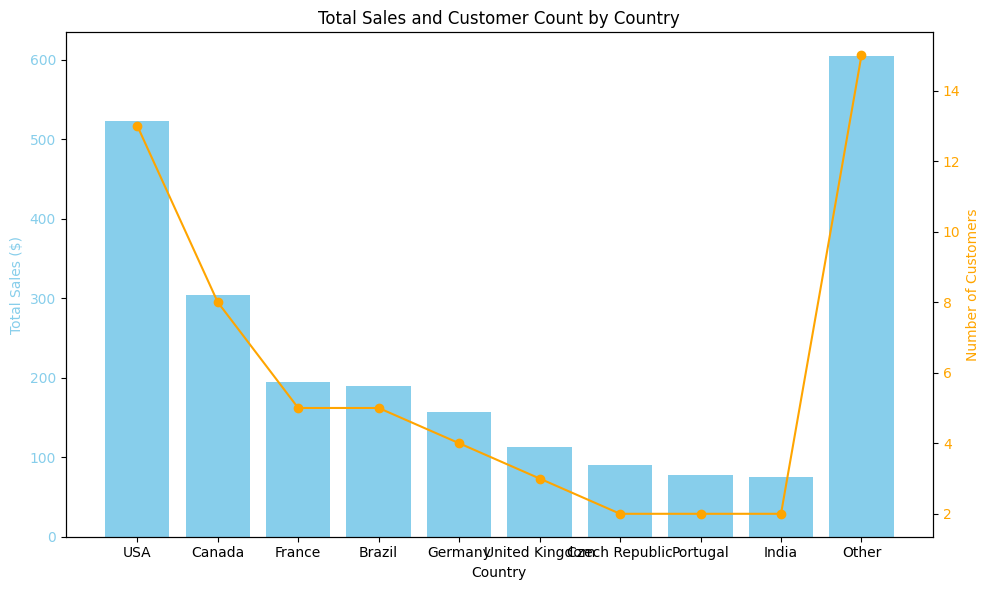

In [34]:
import matplotlib.pyplot as plt

query = """
WITH customer_count AS (
    SELECT country, COUNT(*) AS num_customers
    FROM customer
    GROUP BY country
),
labeled_invoices AS (
    SELECT CASE WHEN cc.num_customers = 1 THEN 'Other'
        ELSE c.country
    END AS country,
    i.CustomerId,
    i.InvoiceId,
    il.UnitPrice
    FROM InvoiceLine AS il
    JOIN invoice AS i USING (InvoiceId)
    JOIN customer AS c ON i.CustomerId = c.CustomerId
    JOIN customer_count AS cc ON cc.country = c.country
)
SELECT country,
    COUNT(DISTINCT CustomerId) AS customers,
    SUM(UnitPrice) AS total_sales
FROM labeled_invoices
GROUP BY country
ORDER BY CASE WHEN country = 'Other' THEN 1 ELSE 0 END, 3 DESC
"""

# Fetch the data
df = pd.read_sql(query, conn)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for total_sales
ax1.bar(df['country'], df['total_sales'], color='skyblue', label='Total Sales')
ax1.set_ylabel('Total Sales ($)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xlabel('Country')

# Line chart (or twin axis) for number of customers
ax2 = ax1.twinx()
ax2.plot(df['country'], df['customers'], color='orange', marker='o', label='Customers')
ax2.set_ylabel('Number of Customers', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and layout
plt.title('Total Sales and Customer Count by Country')
fig.tight_layout()
plt.show()

#Which artist is used in the most playlists?
We’ll now count how often tracks by each artist appear in playlists

In [36]:
query = """
SELECT ar.Name AS Artist, COUNT(*) AS PlaylistAppearances
FROM PlaylistTrack pt
JOIN Track t ON pt.TrackId = t.TrackId
JOIN Album al ON t.AlbumId = al.AlbumId
JOIN Artist ar ON al.ArtistId = ar.ArtistId
GROUP BY ar.ArtistId
ORDER BY PlaylistAppearances DESC
LIMIT 1;
"""

pd.read_sql(query, conn)

,Artist,PlaylistAppearances
0,Iron Maiden,516


#How many tracks have been purchased vs not purchased?
Purchased tracks are those that appear in the `InvoiceLine` table. We'll compare purchased and unpurchased counts

In [40]:
query = """
SELECT
  CASE WHEN il.TrackId IS NOT NULL THEN 'Purchased' ELSE 'Not Purchased' END AS PurchaseStatus,
  COUNT(*) AS TrackCount
FROM Track t
LEFT JOIN InvoiceLine il ON t.TrackId = il.TrackId
GROUP BY PurchaseStatus
ORDER BY TrackCount DESC
"""
pd.read_sql(query, conn)

,PurchaseStatus,TrackCount
0,Purchased,2240
1,Not Purchased,1519


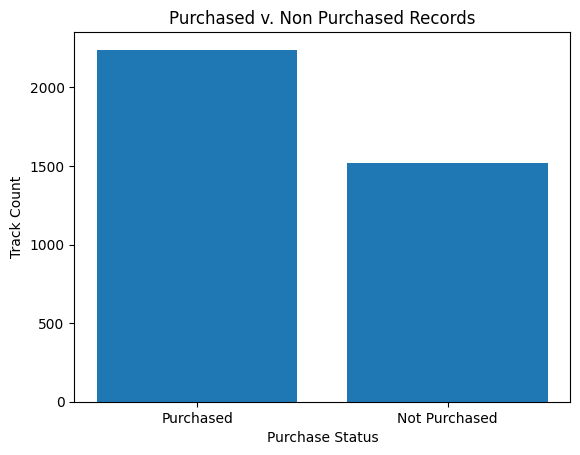

In [51]:
query = """
SELECT
  CASE WHEN il.TrackId IS NOT NULL THEN 'Purchased' ELSE 'Not Purchased' END AS PurchaseStatus,
  COUNT(*) AS TrackCount
FROM Track t
LEFT JOIN InvoiceLine il ON t.TrackId = il.TrackId
GROUP BY PurchaseStatus
ORDER BY TrackCount DESC
"""
df = pd.read_sql(query, conn)

plt.bar(df['PurchaseStatus'], df['TrackCount'])
plt.title('Purchased v. Non Purchased Records')
plt.xlabel('Purchase Status')
plt.ylabel('Track Count')
plt.show()

#Is the range of tracks in the store reflective of their sales popularity?

We compare the number of tracks per genre to the total sales per genre

In [43]:
query = """
WITH track_counts AS (
  SELECT g.Name AS Genre, COUNT(t.TrackId) AS TrackCount
  FROM Track t
  JOIN Genre g ON t.GenreId = g.GenreId
  GROUP BY g.GenreId
),

genre_sales AS (
  SELECT g.Name AS Genre, SUM(il.UnitPrice * il.Quantity) AS TotalSales
  FROM InvoiceLine il
  JOIN Track t ON il.TrackId = t.TrackId
  JOIN Genre g ON t.GenreId = g.GenreId
  GROUP BY g.GenreId
)

SELECT tc.Genre, tc.TrackCount, gs.TotalSales
FROM track_counts tc
LEFT JOIN genre_sales gs ON tc.Genre = gs.Genre
ORDER BY gs.TotalSales DESC;
"""

pd.read_sql(query, conn)


,Genre,TrackCount,TotalSales
0,Rock,1297,826.65
1,Latin,579,382.14
2,Metal,374,261.36
3,Alternative & Punk,332,241.56
4,TV Shows,93,93.53
5,Jazz,130,79.20
6,Blues,81,60.39
7,Drama,64,57.71
8,R&B/Soul,61,40.59
9,Classical,74,40.59


#Do protected vs non-protected media types have an effect on popularity?

We'll compare sales across media types

In [47]:
query = """
        SELECT * FROM MediaType
        LIMIT 5;
        """

pd.read_sql(query, conn)

,MediaTypeId,Name
0,1,MPEG audio file
1,2,Protected AAC audio file
2,3,Protected MPEG-4 video file
3,4,Purchased AAC audio file
4,5,AAC audio file


In [48]:
query = """
SELECT m.Name AS MediaType,
       COUNT(DISTINCT t.TrackId) AS NumberOfTracks,
       SUM(il.UnitPrice * il.Quantity) AS TotalSales
FROM MediaType m
JOIN Track t ON t.MediaTypeId = m.MediaTypeId
LEFT JOIN InvoiceLine il ON t.TrackId = il.TrackId
GROUP BY m.MediaTypeId
ORDER BY TotalSales DESC;
"""

pd.read_sql(query, conn)

,MediaType,NumberOfTracks,TotalSales
0,MPEG audio file,3034,1956.24
1,Protected MPEG-4 video file,214,220.89
2,Protected AAC audio file,237,144.54
3,Purchased AAC audio file,7,3.96
4,AAC audio file,11,2.97


We can see that the MPEG file is more popular than Protected MPEG file by a **huge** margin. This definitely means that the unprotected media type is more popular.

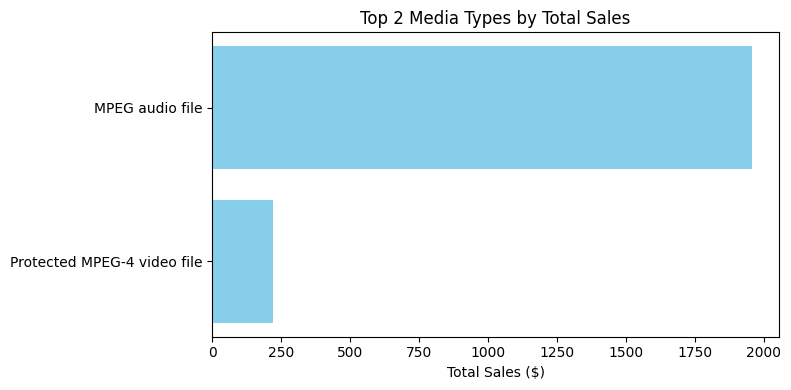

In [50]:
query = """
SELECT m.Name AS MediaType,
       COUNT(DISTINCT t.TrackId) AS NumberOfTracks,
       SUM(il.UnitPrice * il.Quantity) AS TotalSales
FROM MediaType m
JOIN Track t ON t.MediaTypeId = m.MediaTypeId
LEFT JOIN InvoiceLine il ON t.TrackId = il.TrackId
GROUP BY m.MediaTypeId
ORDER BY TotalSales DESC;
"""
df = pd.read_sql(query, conn)
df_top2 = df.head(2)

plt.figure(figsize=(8, 4))
plt.barh(df_top2['MediaType'], df_top2['TotalSales'], color='skyblue')
plt.xlabel('Total Sales ($)')
plt.title('Top 2 Media Types by Total Sales')
plt.gca().invert_yaxis()  # Highest sales on top
plt.tight_layout()
plt.show()

And this visualizes the stark differences between the sales of two media types.